The data is present in two files: `data.csv` and `day_features.csv`.

`data.csv` contains the following features:
 - `Date`
 - `Day`:              the day of the week
 - `Holiday`: 0 or 1 - whether it was a holiday
 - `Meal`:             which meal it was (Breakfast, Lunch, Tea, Dinner)
 - `Work`:    1 to 5 - a rating of how busy I was that day
It also contains the target `Time`, the time spent (in minutes) eating that meal.

`day_features.csv` contains the following features:
 - `Day`:              the day of the week
 - `9:00?`:   0 or 1 - whether there was a class at 9:00
 - `12:00?`:  0 or 1 - whether there was a class at 12:00
 - `2:30?`:   0 or 1 - whether there was a class at 2:30
 - `Quality`: 1 to 10-  a rating of the menu for that meal
   - 4 ratings, one for each meal

The reason for the two files is that the day features are the same for a given day, regardless of the date/meal, so this removes some redundancy.


In [1]:
# import and combine both csv files into the dataset

import pandas as pd

# Read the data from the csv file
data = pd.read_csv('data.csv')

# Read the day features from the csv file (for the design matrix)
day_features = pd.read_csv('day_features.csv')

meals = ['Breakfast', 'Lunch', 'Tea', 'Dinner']

# replace strings with numbers
data['Meal'] = data['Meal'].replace(meals, range(len(meals)))
data['Holiday'] = (data['Holiday'] == 'Yes') * 1

# add per-day features from day_features.csv
data = data.join(day_features.set_index('Day'), on='Day')

# combine 'Breakfast', 'Lunch', etc from day_features into a single 'Quality' feature
for i, meal in enumerate(meals):
    data.loc[data['Meal'] == i, 'Quality'] = data.loc[data['Meal'] == i, meal]
# drop the individual quality columns
data = data.drop(meals, axis=1)

# `9:00?` only matters if the meal is lunch, and so on
data.loc[data['Meal'] != 0, '9:00?'] = 0
data.loc[data['Meal'] != 1, '12:00?'] = 0
data.loc[data['Meal'] != 1, '2:30?'] = 0

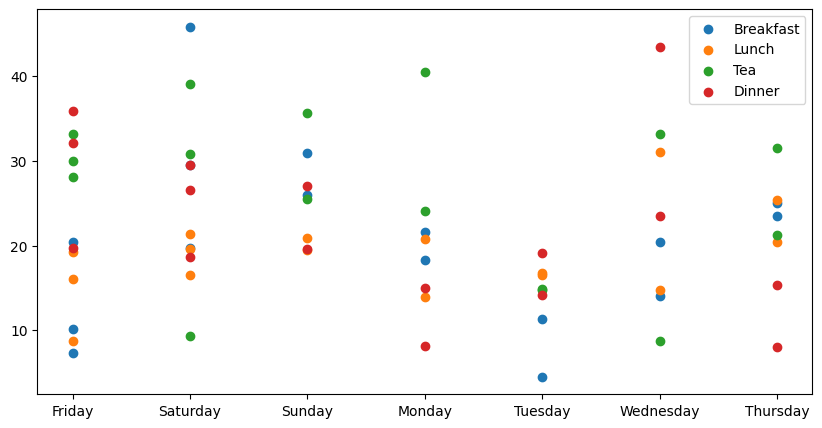

In [2]:
# Part A: A plot showing time spent on different days for different meals

import matplotlib.pyplot as plt
import numpy as np

time_copy = data['Time'].copy()
# add small random noise to the time to make the points more visible
# (This is because most of the time points are rounded to the nearest 5 minutes)
time_copy += (time_copy.max() - time_copy.min()) * 0.1 * (np.random.rand(len(time_copy)) - 0.5)


for i, meal in enumerate(meals):
    data_meal = data[data['Meal'] == i]
    plt.scatter(data_meal['Day'], time_copy[data_meal.index], label=meal)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()


From the graph, we can make some simple inferences:
 - I always eat quickly on Tuesdays
 - Tea is generally the longest meal
 - Breakfast is fast on Tuesday and Fridays (because those are the only days when I have a class at 9 AM

For this data, we attempt to use Regularized Poisson regression instead of Linear Regression

The pmf for this distribution is
\begin{equation}
  p(y | \mathbf{x}, \mathbf{w}) = \prod_{i=1}^{m}{\frac{e^{y_{i} \mathbf{w}^{T} \mathbf{x}_{i}} e^{e^{-\mathbf{w}^{T} \mathbf{x}_{i}}}}{y_{i}!}}
\end{equation}

The log likelihood equation is
\begin{align}
  -\ln{p(y | \mathbf{x}, \mathbf{w})} &= - \sum_{i=1}^{m}{y_{i} \mathbf{w}^{T} \mathbf{x}_{i}}
                                         + \sum_{i=1}^{m}{e^{-\mathbf{w}^{T} \mathbf{x}_{i}}}
                                         + \sum_{i=1}^{m}{\ln{y_{i}!}} \\
                                      &= - \sum_{i=1}^{m}{y_{i} \mathbf{w}^{T} \mathbf{x}_{i}}
                                         + \sum_{i=1}^{m}{e^{-\mathbf{w}^{T} \mathbf{x}_{i}}}
                                         + \text{constant}
\end{align}

So adding a regularization term to the log likelihood equation, we get our error function,
\begin{equation}
   E_{D}(\mathbf{w}) = \frac{1}{m}
                     \left(
                      \sum_{i=1}^{m}{y_{i} \mathbf{w}^{T} \mathbf{x}_{i}}
                      - \sum_{i=1}^{m}{e^{-\mathbf{w}^{T} \mathbf{x}_{i}}}
                     \right)
                       + \frac{\lambda}{2} \left\lVert \mathbf{w} \right\rVert^{2}
\end{equation}

For gradient descent, we find the gradient,
\begin{align}
  \nabla \left(E_{D}(\mathbf{w})\right) &= \frac{1}{m}
                                           \left(
                                            \sum_{i=1}^{m}{y_{i} \mathbf{x}_{i}}
                                            - \sum_{i=1}^{m}{e^{-\mathbf{w}^{T} \mathbf{x}_{i}} \mathbf{x}_{i}}
                                           \right)
                                           + \lambda \mathbf{w} \\
                                        &= \frac{1}{m} \sum_{i=1}^{m}{(\hat{y}_{i} - y_{i}) \mathbf{x}_{i}}
                                           + \lambda \mathbf{w} \\
                                  &= \frac{1}{m} \sum_{i=1}^{m}{(\hat{y}_{i} - y_{i}) \mathbf{x}_{i}}
                                     + \lambda \mathbf{w}
\end{align}

In the below code, we use gradient descent, assuming $\lambda$ is 1.


In [3]:
import numpy as np

class PoissonRegression:

    def __init__(self, alpha=0.01, n_iter=1000, lamb=1):
        self.alpha = alpha
        self.n_iter = n_iter
        self.weights = None
        self.lamb = lamb

    def fit(self, X, y):
        # initialize weights
        # if dataframe, convert to numpy array
        if type(X) == pd.DataFrame:
            X = X.to_numpy()
        new_X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        self.weights = np.ones(new_X.shape[1], dtype=np.float64)

        for _ in range(self.n_iter):
            # calculate the predicted y values
            y_pred = self.predict(X)
            
            gradient = np.dot(new_X.T, y_pred - y) / len(y) + self.weights * self.lamb

            # update the weights
            self.weights -= self.alpha * gradient

    def predict(self, X):
        if self.weights is None:
            raise Exception("Model not yet trained")
        new_X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        return np.exp(np.dot(new_X, self.weights))

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

X = data.drop(['Date', 'Time', 'Day'], axis=1).astype(float)
y = data['Time'].astype(float)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# StandardScaler scales each feature to have mean 0 and variance 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the Poisson model
model = PoissonRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate the mean squared error
print("Features:", X.columns)
print("Weights:", np.array([model.weights]).T)
print(mean_squared_error(y_test, y_pred))


Features: Index(['Holiday', 'Meal', 'Work', '9:00?', '12:00?', '2:30?', 'Quality'], dtype='object')
Weights: [[ 0.0584006 ]
 [ 0.02719431]
 [-0.16477654]
 [-0.24880471]
 [-0.05857096]
 [-0.02750987]
 [ 0.10431608]
 [ 2.89375776]]
60.285105910742224


Since there are very few datapoints, the importance of different features seems to vary a lot per run. But on average, we see that the most important feature seems to be `Work`, followed by `9:00?`, `2:30?`, and `Quality`.

We are using the mean squared error to check the accuracy of the model. Over multiple runs, the MSE varies from 30-120, meaning that the model's predictions seem to be off by 5-10 minutes. Given that the range of times is in the range 5-45 minutes, and that the true times will obviously have a lot of variance, this time seems acceptable. 

In [5]:
from sklearn.linear_model import LinearRegression

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# StandardScaler scales each feature to have mean 0 and variance 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

74.40953192156373


When using scikit-learn's builtin `LinearRegression` model, the MSE varies in the 50-110 range over many runs.

On average, Regularized Poisson Regression appears to perform slightly better than the Regularized Linear model on this dataset.